In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import json

metadata_file = 'free-spoken-digit-dataset-master\metadata.py'

with open(metadata_file) as f:
    code = f.read()
    exec(code)

df = pd.DataFrame(metadata)
df=df.T
df


,gender,accent,language
jackson,male,USA/neutral,english
nicolas,male,BEL/French,english
theo,male,USA/neutral,english
yweweler,male,DEU/German,english
george,male,GRC/Greek,english
lucas,male,DEU/German,english


# Data Analysis

## Checking durations of audio files

Processing audio files: 100%|██████████| 3000/3000 [00:08<00:00, 359.24file/s]


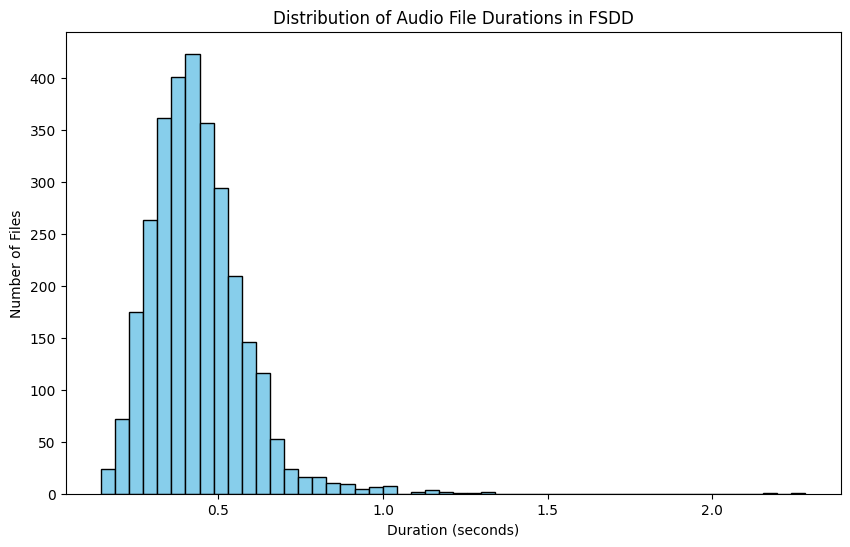

In [2]:
import soundfile as sf
from tqdm import tqdm

base_dir = 'C:/Users/kshit/Desktop/DL Lab Miniproj/free-spoken-digit-dataset-master/recordings'
durations = []
total_files = len([f for f in os.listdir(base_dir) if f.endswith('.wav')])

with tqdm(total=total_files, desc="Processing audio files", unit="file") as pbar:
    wav_files = [f for f in os.listdir(base_dir) if f.endswith('.wav')]
    
    for wav_file in wav_files:
        wav_path = os.path.join(base_dir, wav_file)
        
        with sf.SoundFile(wav_path) as f:
            duration = len(f) / f.samplerate 
            durations.append(duration)
        
        pbar.update(1)  

plt.figure(figsize=(10, 6))
plt.hist(durations, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio File Durations in FSDD')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Files')
plt.show()


## Checking sample rate of audio

In [3]:
from collections import defaultdict

sample_rates = defaultdict(int)  
total_files = len([f for f in os.listdir(base_dir) if f.endswith('.wav')])

with tqdm(total=total_files, desc="Processing audio files", unit="file") as pbar:
    wav_files = [f for f in os.listdir(base_dir) if f.endswith('.wav')]
    
    for wav_file in wav_files:
        wav_path = os.path.join(base_dir, wav_file)
        with sf.SoundFile(wav_path) as f:
            sample_rate = f.samplerate  
            sample_rates[sample_rate] += 1  
        
        pbar.update(1)  

print("Unique Sample Rates and their Counts:")
for rate, count in sample_rates.items():
    print(f"Sample Rate: {rate} Hz, Count: {count} files")


Processing audio files: 100%|██████████| 3000/3000 [00:00<00:00, 11859.56file/s]

Unique Sample Rates and their Counts:
Sample Rate: 8000 Hz, Count: 3000 files


#### All files have the same sample rate so no need to resample the audio files to ensure consistency

### Checking amplitude of audio files

Calculating average amplitudes: 100%|██████████| 3000/3000 [00:00<00:00, 5833.31file/s]


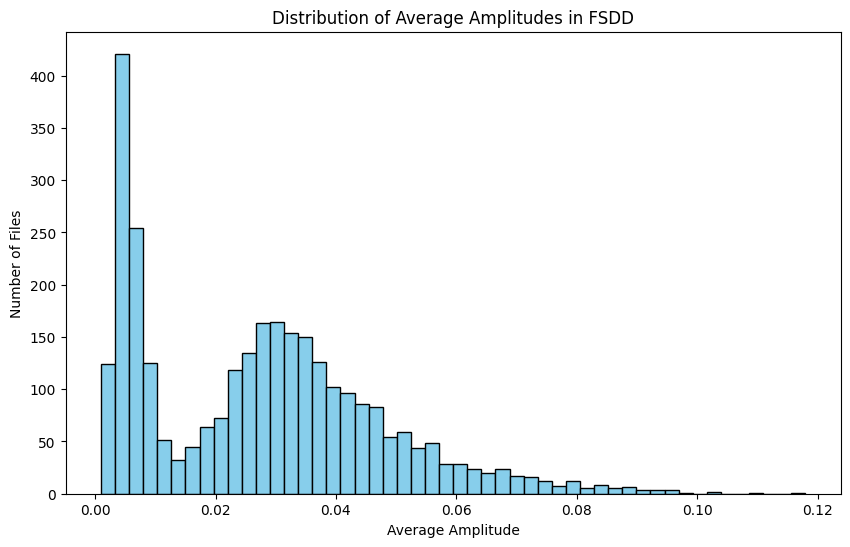

In [4]:
avg_amplitudes = []
total_files = len([f for f in os.listdir(base_dir) if f.endswith('.wav')])

with tqdm(total=total_files, desc="Calculating average amplitudes", unit="file") as pbar:
    wav_files = [f for f in os.listdir(base_dir) if f.endswith('.wav')]
    
    for wav_file in wav_files:
        wav_path = os.path.join(base_dir, wav_file)
        
        with sf.SoundFile(wav_path) as f:
            data = f.read()
            avg_amplitude = np.mean(np.abs(data))
            avg_amplitudes.append(avg_amplitude)
        
        pbar.update(1) 

plt.figure(figsize=(10, 6))
plt.hist(avg_amplitudes, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Amplitudes in FSDD')
plt.xlabel('Average Amplitude')
plt.ylabel('Number of Files')
plt.show()


### Checking silence in audio files

Processing audio files for silences: 100%|██████████| 3000/3000 [00:00<00:00, 6929.13file/s]


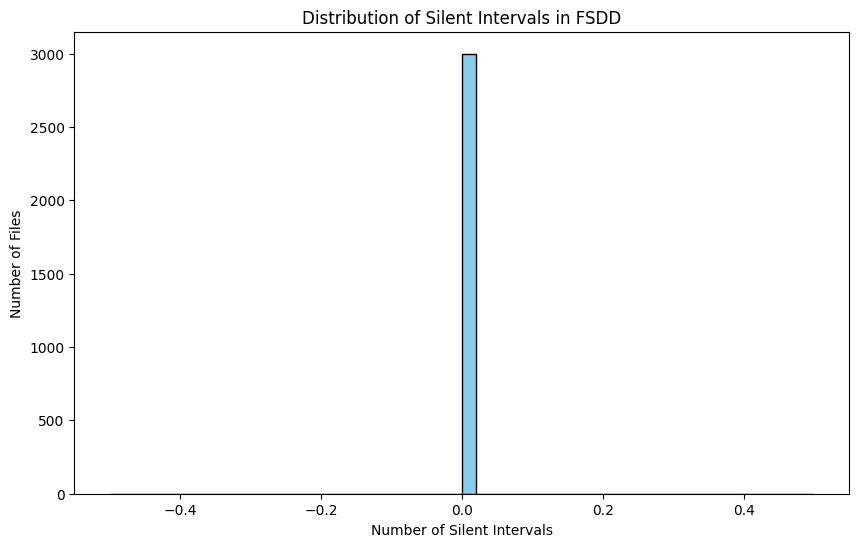

In [5]:
silences = []
silence_threshold = 0.01 
silence_duration_threshold = 0.5  
total_files = len([f for f in os.listdir(base_dir) if f.endswith('.wav')])
with tqdm(total=total_files, desc="Processing audio files for silences", unit="file") as pbar:
    wav_files = [f for f in os.listdir(base_dir) if f.endswith('.wav')]
    
    for wav_file in wav_files:
        wav_path = os.path.join(base_dir, wav_file)
        
        with sf.SoundFile(wav_path) as f:
            data = f.read()
            sample_rate = f.samplerate
            silence = np.where(np.abs(data) < silence_threshold)[0]
            
            if len(silence) > 0:
                silence_durations = np.diff(silence)
                silent_intervals = np.sum(silence_durations > silence_duration_threshold * sample_rate)
                silences.append(silent_intervals)
            else:
                silences.append(0)
        
        pbar.update(1)  

plt.figure(figsize=(10, 6))
plt.hist(silences, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Silent Intervals in FSDD')
plt.xlabel('Number of Silent Intervals')
plt.ylabel('Number of Files')
plt.show()


#### None of the files have silent intervals so no need to trim silences

# Preprocessing - Feature Extraction 

In [6]:
import librosa
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

data = []
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)  
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCC features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Extract chroma features
    spectrogram = np.abs(librosa.stft(y))  # Spectrogram (Short-time Fourier transform)
    return mfcc, chroma, spectrogram

wav_files = [f for f in os.listdir(base_dir) if f.endswith('.wav')]  

for wav_file in wav_files:
    wav_path = os.path.join(base_dir, wav_file)
    
    digit = int(wav_file.split('_')[0])
    speaker = wav_file.split('_')[1]
    sample_number = int(wav_file.split('_')[2].split('.')[0])
    
    mfcc, chroma, spectrogram = extract_features(wav_path)
    
    data.append({
        'file_name': wav_file,
        'digit': digit,
        'speaker': speaker,
        'sample_number': sample_number,
        'mfcc': mfcc,
        'chroma': chroma,
        'spectrogram': spectrogram
    })

df_data = pd.DataFrame(data)
df_data


,file_name,digit,speaker,sample_number,mfcc,chroma,spectrogram
0,0_george_0.wav,0,george,0,"[[-155.43077, -134.53027, -166.09628, -172.844...","[[0.1536109, 0.1359337, 0.10263667, 0.04200427...","[[0.3839967, 0.17563055, 0.026241675, 0.040250..."
1,0_george_1.wav,0,george,1,"[[-356.78818, -289.81583, -259.7527, -257.5529...","[[0.0063295946, 0.0044739554, 0.005950157, 0.0...","[[0.0065461677, 0.014208472, 0.026184324, 0.02..."
2,0_george_10.wav,0,george,10,"[[-419.07782, -435.91333, -454.72885, -367.873...","[[1.0, 1.0, 0.13688238, 0.015554002, 0.0080961...","[[0.020438923, 0.027283745, 0.025866315, 0.025..."
3,0_george_11.wav,0,george,11,"[[-318.20068, -235.42369, -218.94463, -188.362...","[[0.033487294, 0.2117787, 0.50708324, 0.406937...","[[0.013833046, 0.010388312, 0.026009453, 0.026..."
4,0_george_12.wav,0,george,12,"[[-313.86572, -248.42844, -228.21733, -199.885...","[[0.015710793, 0.037154756, 0.10830031, 0.1133...","[[0.0132975485, 0.010960613, 0.026074836, 0.02..."
...,...,...,...,...,...,...,...
2995,9_yweweler_5.wav,9,yweweler,5,"[[-374.88925, -299.90396, -267.3155, -246.2213...","[[1.0, 1.0, 0.34247884, 0.9680629, 0.8566324, ...","[[0.019378161, 0.028168315, 0.02847826, 0.0225..."
2996,9_yweweler_6.wav,9,yweweler,6,"[[-344.1823, -249.03813, -204.8138, -218.9355,...","[[0.74427074, 0.5465318, 0.3470095, 0.18787208...","[[0.05104033, 0.059488855, 0.015533547, 0.0013..."
2997,9_yweweler_7.wav,9,yweweler,7,"[[-323.3762, -273.50427, -240.43558, -232.7812...","[[0.14174257, 0.095494375, 0.21600138, 0.53786...","[[0.0072739897, 0.013656021, 0.017249193, 0.02..."
2998,9_yweweler_8.wav,9,yweweler,8,"[[-436.94446, -342.70953, -330.32166, -301.525...","[[0.1694638, 0.1820855, 0.29766464, 0.20925541...","[[0.011548543, 0.019818036, 0.019741202, 0.028..."


In [7]:
print(df_data.dtypes)

file_name        object
digit             int64
speaker          object
sample_number     int64
mfcc             object
chroma           object
spectrogram      object
dtype: object


In [8]:
df_data['digit'].value_counts()

digit
0    300
1    300
2    300
3    300
4    300
5    300
6    300
7    300
8    300
9    300
Name: count, dtype: int64

In [9]:
df_data['speaker'].value_counts()

speaker
george      500
jackson     500
lucas       500
nicolas     500
theo        500
yweweler    500
Name: count, dtype: int64

In [10]:
import random
import IPython.display as ipd

random_row = df_data.sample(n=1).iloc[0]
audio_path = os.path.join(base_dir, random_row['file_name'])
ipd.display(ipd.Audio(audio_path))


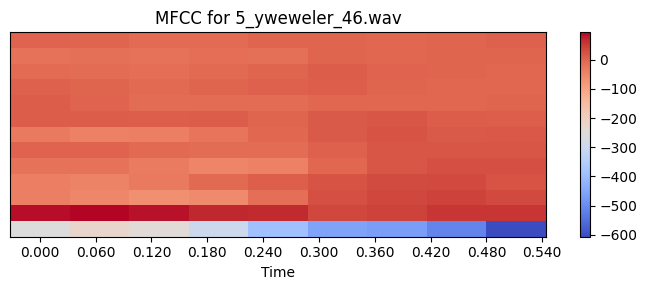

In [11]:
import librosa.display

random_row = df_data.sample(n=1).iloc[0]
mfcc = random_row['mfcc']

plt.figure(figsize=(7, 3))
librosa.display.specshow(mfcc, sr=8000, x_axis='time') 
plt.colorbar()
plt.title(f"MFCC for {random_row['file_name']}")
plt.tight_layout()
plt.show()


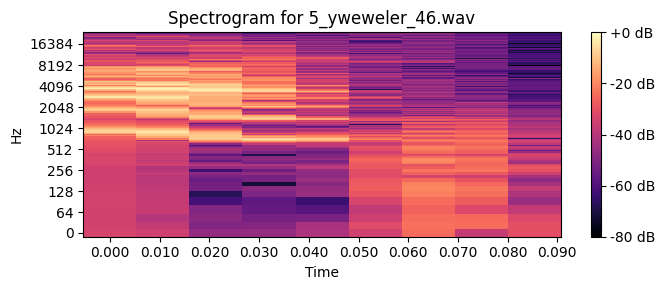

In [12]:
spectrogram = random_row['spectrogram']

plt.figure(figsize=(7, 3))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=48000, x_axis='time', y_axis='log')  
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram for {random_row['file_name']}")
plt.tight_layout()
plt.show()

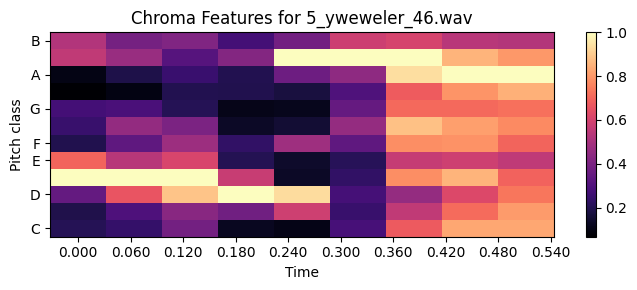

In [13]:
chroma = random_row['chroma']

plt.figure(figsize=(7, 3))
librosa.display.specshow(chroma, sr=8000 , x_axis='time', y_axis='chroma')  
plt.colorbar()
plt.title(f"Chroma Features for {random_row['file_name']}")
plt.tight_layout()
plt.show()


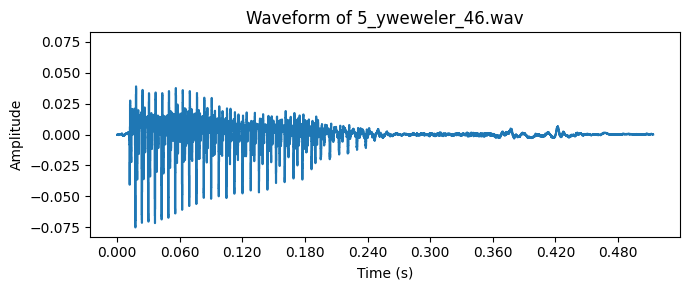

In [14]:
audio_path = os.path.join(base_dir, random_row['file_name'])
y, sr = librosa.load(audio_path, sr=None)  
plt.figure(figsize=(7, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {random_row['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


# Data Extraction for CNN

In [15]:
import os
import wave
import pylab
from tqdm import tqdm
from pathlib import Path

input_dir = 'C:/Users/kshit/Desktop/DL Lab Miniproj/free-spoken-digit-dataset-master/recordings'
output_dir = 'C:/Users/kshit/Desktop/DL Lab Miniproj/free-spoken-digit-dataset-master/data_extraction/'

def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

if not os.path.exists(os.path.join(output_dir, 'audio-images')):
    os.mkdir(os.path.join(output_dir, 'audio-images'))

wav_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]
for filename in tqdm(wav_files, desc="Processing audio files", unit="file"):
    file_path = os.path.join(input_dir, filename)
    file_stem = Path(file_path).stem
    target_dir = f'class_{file_stem[0]}'
    dist_dir = os.path.join(os.path.join(output_dir, 'audio-images'), target_dir)
    file_dist_path = os.path.join(dist_dir, file_stem)
    
    if not os.path.exists(file_dist_path + '.png'):
        if not os.path.exists(dist_dir):
            os.mkdir(dist_dir)
        
        sound_info, frame_rate = get_wav_info(file_path)
        
        pylab.specgram(sound_info, Fs=frame_rate)
        pylab.savefig(f'{file_dist_path}.png')
        pylab.close()


Processing audio files: 100%|██████████| 3000/3000 [00:00<00:00, 8350.35file/s] 


In [16]:
import tensorflow as tf
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=32,
                                             validation_split=0.2,
                                             directory=os.path.join(output_dir, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             subset="training",
                                             seed=0)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=32,
                                             validation_split=0.2,
                                             directory=os.path.join(output_dir, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             subset="validation",
                                             seed=0)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


In [17]:
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


In [18]:
print(train_dataset.class_names)
print(valid_dataset.class_names)


['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


### CNN Model 1


In [19]:
import tensorflow as tf

model_cnn_1 = tf.keras.models.Sequential()
model_cnn_1.add(tf.keras.layers.Input(shape=(256, 256, 3)))
model_cnn_1.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model_cnn_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_1.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model_cnn_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_1.add(tf.keras.layers.Flatten())
model_cnn_1.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_1.add(tf.keras.layers.Dense(10, activation='softmax'))

model_cnn_1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)
history_cnn_1 = model_cnn_1.fit(train_dataset, epochs=10, validation_data=valid_dataset)



Epoch 1/10


75/75 [==============================] - 15s 186ms/step - loss: 107.8057 - accuracy: 0.2254 - val_loss: 2.1427 - val_accuracy: 0.2717
Epoch 2/10
75/75 [==============================] - 13s 176ms/step - loss: 3.2412 - accuracy: 0.2454 - val_loss: 1.8036 - val_accuracy: 0.3500
Epoch 3/10
75/75 [==============================] - 14s 179ms/step - loss: 2.8812 - accuracy: 0.3142 - val_loss: 1.7438 - val_accuracy: 0.4317
Epoch 4/10
75/75 [==============================] - 14s 183ms/step - loss: 1.6841 - accuracy: 0.4596 - val_loss: 1.1880 - val_accuracy: 0.6433
Epoch 5/10
75/75 [==============================] - 13s 173ms/step - loss: 1.9884 - accuracy: 0.7721 - val_loss: 0.4806 - val_accuracy: 0.8567
Epoch 6/10
75/75 [==============================] - 13s 173ms/step - loss: 0.5026 - accuracy: 0.8825 - val_loss: 0.3948 - val_accuracy: 0.9017
Epoch 7/10
75/75 [==============================] - 15s 204ms/step - loss: 0.6966 - accuracy: 0.8963 - val_loss: 0.4701 - val_accuracy: 

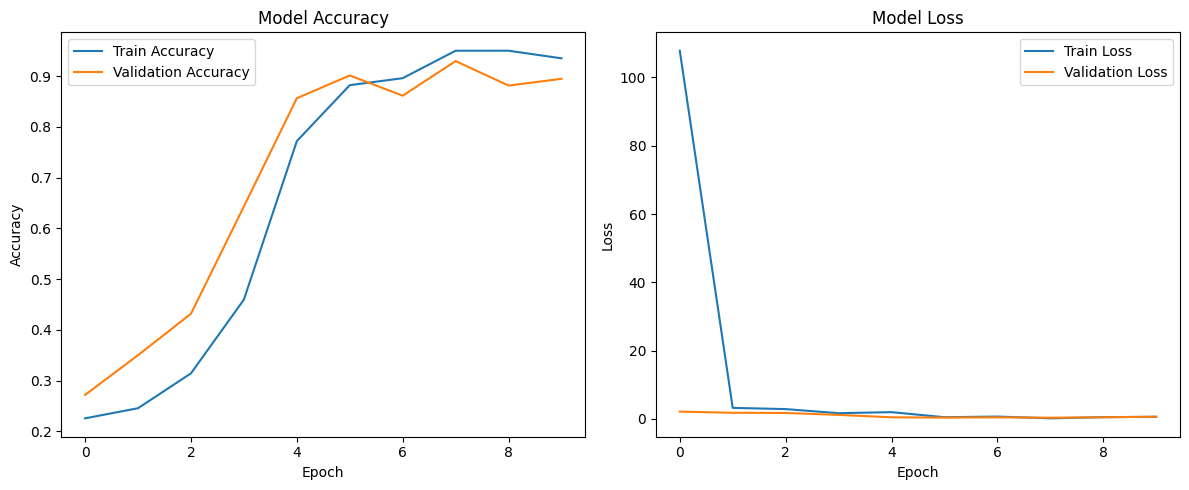

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_1.history['loss'], label='Train Loss')
plt.plot(history_cnn_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
final_loss, final_acc = model_cnn_1.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.654126, final accuracy: 0.895000


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = np.concatenate([y for x, y in valid_dataset], axis=0)
y_pred = np.argmax(model_cnn_1.predict(valid_dataset), axis=1)

print(classification_report(y_true, y_pred, target_names=valid_dataset.class_names))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)


19/19 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

     class_0       0.14      0.15      0.15        52
     class_1       0.14      0.13      0.14        52
     class_2       0.07      0.06      0.06        69
     class_3       0.11      0.12      0.11        60
     class_4       0.18      0.19      0.18        69
     class_5       0.12      0.11      0.11        55
     class_6       0.13      0.10      0.12        68
     class_7       0.10      0.12      0.11        59
     class_8       0.07      0.07      0.07        54
     class_9       0.07      0.08      0.07        62

    accuracy                           0.11       600
   macro avg       0.11      0.11      0.11       600
weighted avg       0.11      0.11      0.11       600

Confusion Matrix:
 [[ 8  5  7  7  4  1  3  7  3  7]
 [ 5  7  4 11  6  6  4  2  1  6]
 [ 3  4  4  8 10  7  7  9  8  9]
 [ 4  2  5  7 10  4  8  4  5 11]
 [ 6  2  4  6 13  8  4  9  8  9]
 [1

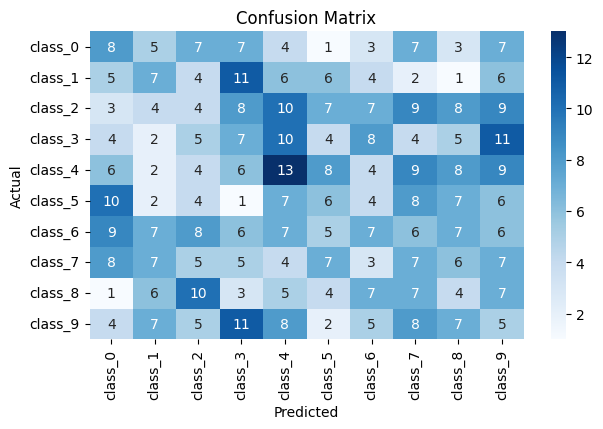

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_dataset.class_names, yticklabels=valid_dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [24]:
model_cnn_1.save(os.path.join(output_dir, 'model_cnn_1.h5'))

In [25]:
model_comparison_df = pd.DataFrame(columns=['Model', 'Epochs', 'Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'])

epochs_cnn_1 = len(history_cnn_1.history['accuracy'])  

model_cnn_1_results = pd.DataFrame({
    'Model': ['CNN Model 1'],
    'Epochs': [epochs_cnn_1],  
    'Train Accuracy': [history_cnn_1.history['accuracy'][-1]],  
    'Validation Accuracy': [history_cnn_1.history['val_accuracy'][-1]], 
    'Train Loss': [history_cnn_1.history['loss'][-1]],  
    'Validation Loss': [history_cnn_1.history['val_loss'][-1]]  
})

model_comparison_df = pd.concat([model_comparison_df, model_cnn_1_results], ignore_index=True)
print(model_comparison_df)


         Model Epochs  Train Accuracy  Validation Accuracy  Train Loss  \
0  CNN Model 1     10        0.935417                0.895    0.617536   

   Validation Loss  
0         0.654126  


### Increasing epochs to check if the model overfits or not

In [26]:
import tensorflow as tf

model_cnn_2 = tf.keras.models.Sequential()
model_cnn_2.add(tf.keras.layers.Input(shape=(256, 256, 3)))
model_cnn_2.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model_cnn_2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(tf.keras.layers.Flatten())
model_cnn_2.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_2.add(tf.keras.layers.Dense(10, activation='softmax'))

model_cnn_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)
history_cnn_2 = model_cnn_2.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/20
75/75 [==============================] - 14s 181ms/step - loss: 153.4879 - accuracy: 0.4954 - val_loss: 1.5526 - val_accuracy: 0.4533
Epoch 2/20
75/75 [==============================] - 13s 175ms/step - loss: 1.7618 - accuracy: 0.6133 - val_loss: 1.1755 - val_accuracy: 0.6417
Epoch 3/20
75/75 [==============================] - 13s 171ms/step - loss: 5.6210 - accuracy: 0.7596 - val_loss: 0.8539 - val_accuracy: 0.8383
Epoch 4/20
75/75 [==============================] - 13s 174ms/step - loss: 0.3126 - accuracy: 0.9075 - val_loss: 0.6579 - val_accuracy: 0.8667
Epoch 5/20
75/75 [==============================] - 13s 174ms/step - loss: 1.1245 - accuracy: 0.8929 - val_loss: 1.5308 - val_accuracy: 0.5183
Epoch 6/20
75/75 [==============================] - 13s 171ms/step - loss: 0.7438 - accuracy: 0.9192 - val_loss: 17.7958 - val_accuracy: 0.4800
Epoch 7/20
75/75 [==============================] - 13s 174ms/step - loss: 1.7925 - accuracy: 0.9046 - val_loss: 0.6064 - val_accuracy: 0.8

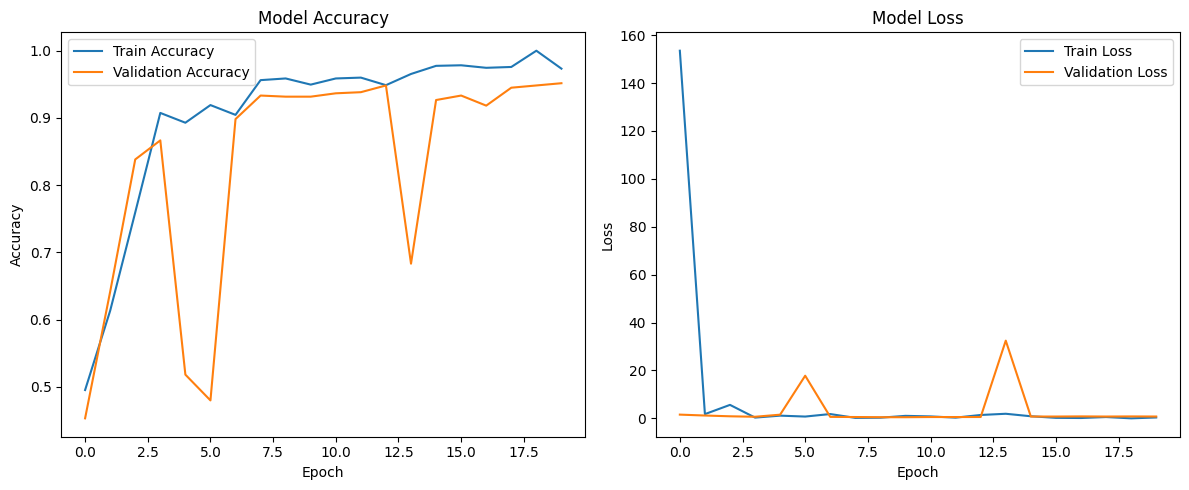

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_2.history['loss'], label='Train Loss')
plt.plot(history_cnn_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
final_loss, final_acc = model_cnn_2.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.758135, final accuracy: 0.951667


In [29]:
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)
y_pred = np.argmax(model_cnn_2.predict(valid_dataset), axis=1)

print(classification_report(y_true, y_pred, target_names=valid_dataset.class_names))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)


19/19 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

     class_0       0.14      0.13      0.14        52
     class_1       0.11      0.10      0.10        52
     class_2       0.13      0.13      0.13        69
     class_3       0.10      0.10      0.10        60
     class_4       0.17      0.17      0.17        69
     class_5       0.11      0.13      0.12        55
     class_6       0.09      0.09      0.09        68
     class_7       0.08      0.08      0.08        59
     class_8       0.11      0.11      0.11        54
     class_9       0.05      0.05      0.05        62

    accuracy                           0.11       600
   macro avg       0.11      0.11      0.11       600
weighted avg       0.11      0.11      0.11       600

Confusion Matrix:
 [[ 7  7  3  4  8  4  7  2  3  7]
 [ 2  5  5  6  4  4  6  7  5  8]
 [ 5  3  9 10 10  3 10  7  5  7]
 [ 3  4  9  6  6 10  4  9  6  3]
 [ 6  4 10  1 12  9  5  8  7  7]
 [ 

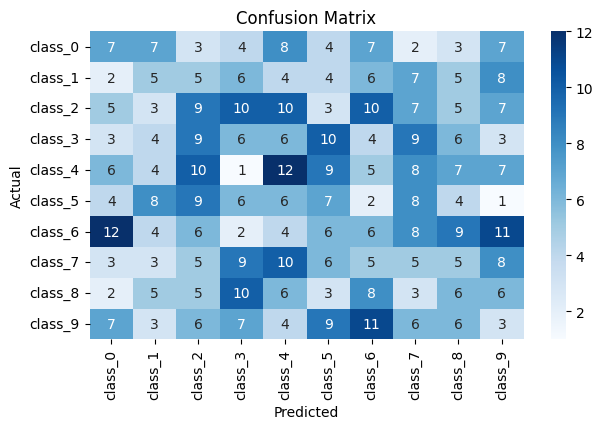

In [30]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_dataset.class_names, yticklabels=valid_dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [31]:
model_cnn_2.save(os.path.join(output_dir, 'model_cnn_2.h5'))

In [32]:
epochs_cnn_2 = len(history_cnn_2.history['accuracy'])  #

model_cnn_2_results = pd.DataFrame({
    'Model': ['CNN Model 2'],
    'Epochs': [epochs_cnn_2],
    'Train Accuracy': [history_cnn_2.history['accuracy'][-1]],
    'Validation Accuracy': [history_cnn_2.history['val_accuracy'][-1]],
    'Train Loss': [history_cnn_2.history['loss'][-1]],
    'Validation Loss': [history_cnn_2.history['val_loss'][-1]]
})

model_comparison_df = pd.concat([model_comparison_df, model_cnn_2_results], ignore_index=True)
print(model_comparison_df)


         Model Epochs  Train Accuracy  Validation Accuracy  Train Loss  \
0  CNN Model 1     10        0.935417             0.895000    0.617536   
1  CNN Model 2     20        0.973333             0.951667    0.364210   

   Validation Loss  
0         0.654126  
1         0.758135  


## Normalization & Data Augmentation

In [33]:
import tensorflow as tf
def prepare(ds, augment=False):
    rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])  # Updated Rescaling without 'experimental'
    
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Updated RandomFlip
        tf.keras.layers.RandomRotation(0.2)  # Updated RandomRotation
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)


In [34]:
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)


### Adding more layers and BatchNormalization & Dropout 

In [35]:
model_cnn_3 = tf.keras.models.Sequential()
model_cnn_3.add(tf.keras.layers.Input(shape=(256, 256, 3)))
model_cnn_3.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.Flatten())
model_cnn_3.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_3.add(tf.keras.layers.BatchNormalization())
model_cnn_3.add(tf.keras.layers.Dropout(0.5))
model_cnn_3.add(tf.keras.layers.Dense(10, activation='softmax'))

model_cnn_3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)
history_cnn_3 = model_cnn_3.fit(train_dataset, epochs=5, validation_data=valid_dataset)

Epoch 1/5
75/75 [==============================] - 21s 263ms/step - loss: 0.6077 - accuracy: 0.8183 - val_loss: 5.5415 - val_accuracy: 0.1150
Epoch 2/5
75/75 [==============================] - 20s 268ms/step - loss: 0.2026 - accuracy: 0.9483 - val_loss: 4.8954 - val_accuracy: 0.1150
Epoch 3/5
75/75 [==============================] - 21s 272ms/step - loss: 0.1046 - accuracy: 0.9750 - val_loss: 3.4232 - val_accuracy: 0.1383
Epoch 4/5
75/75 [==============================] - 20s 264ms/step - loss: 0.0671 - accuracy: 0.9837 - val_loss: 2.5393 - val_accuracy: 0.2883
Epoch 5/5
75/75 [==============================] - 20s 260ms/step - loss: 0.0481 - accuracy: 0.9892 - val_loss: 1.5450 - val_accuracy: 0.5933


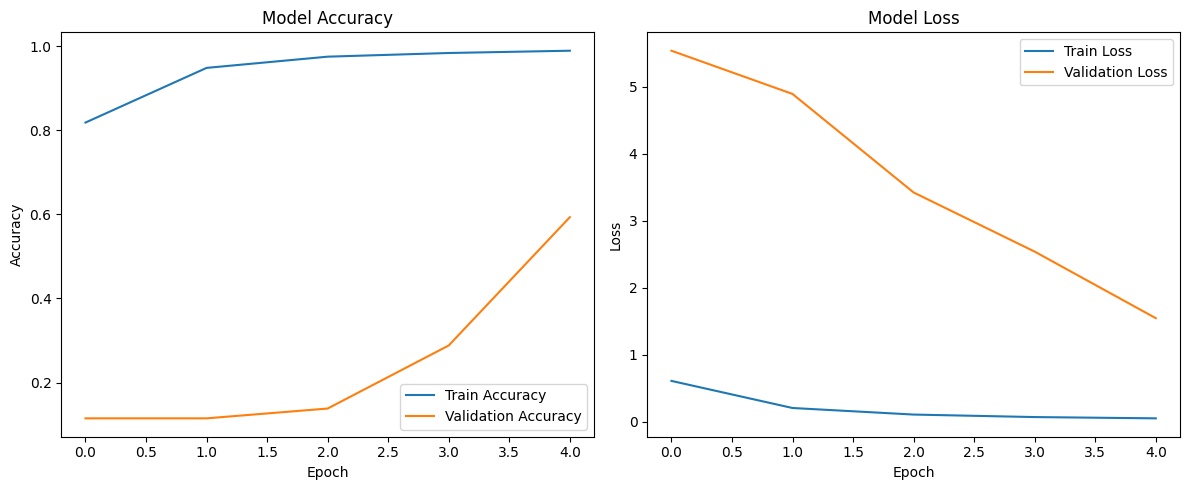

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_3.history['loss'], label='Train Loss')
plt.plot(history_cnn_3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
final_loss, final_acc = model_cnn_3.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 1.544981, final accuracy: 0.593333


In [39]:
y_true = np.concatenate([y for x, y in valid_dataset], axis=0)
y_pred = np.argmax(model_cnn_3.predict(valid_dataset), axis=1)

class_names = [str(i) for i in range(10)]

print(classification_report(y_true, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)


19/19 [==============================] - 2s 71ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.14      0.17      0.16        52
           2       0.10      0.39      0.16        69
           3       0.11      0.10      0.11        60
           4       0.09      0.04      0.06        69
           5       0.00      0.00      0.00        55
           6       0.08      0.07      0.07        68
           7       0.08      0.08      0.08        59
           8       0.07      0.06      0.06        54
           9       0.00      0.00      0.00        62

    accuracy                           0.10       600
   macro avg       0.07      0.09      0.07       600
weighted avg       0.07      0.10      0.07       600

Confusion Matrix:
 [[ 0  3 30  3  1  0  5  6  4  0]
 [ 0  9 19  5  3  0  6  6  4  0]
 [ 1  7 27  3  6  0  9  7  9  0]
 [ 0  5 24  6  4  0 11  7  3  0]
 [ 1 10 26  8  3  2  8  8  3  0]
 [ 

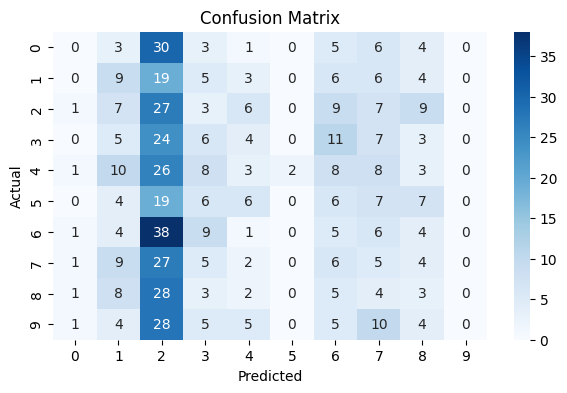

In [41]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



In [42]:
model_cnn_3.save(os.path.join(output_dir, 'model_cnn_3.h5'))

In [43]:
epochs_cnn_3 = len(history_cnn_3.history['accuracy'])  #

model_cnn_3_results = pd.DataFrame({
    'Model': ['CNN Model 3'],
    'Epochs': [epochs_cnn_3],
    'Train Accuracy': [history_cnn_3.history['accuracy'][-1]],
    'Validation Accuracy': [history_cnn_3.history['val_accuracy'][-1]],
    'Train Loss': [history_cnn_3.history['loss'][-1]],
    'Validation Loss': [history_cnn_3.history['val_loss'][-1]]
})

model_comparison_df = pd.concat([model_comparison_df, model_cnn_3_results], ignore_index=True)
print(model_comparison_df)


         Model Epochs  Train Accuracy  Validation Accuracy  Train Loss  \
0  CNN Model 1     10        0.935417             0.895000    0.617536   
1  CNN Model 2     20        0.973333             0.951667    0.364210   
2  CNN Model 3      5        0.989167             0.593333    0.048140   

   Validation Loss  
0         0.654126  
1         0.758135  
2         1.544981  


### Using RNN for timeseries analysis 

In [44]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

dir_path = 'C:/Users/kshit/Desktop/DL Lab Miniproj/free-spoken-digit-dataset-master/recordings/'
data = pd.DataFrame(columns=['raw_data', 'duration', 'digit'])

for filename in tqdm(os.listdir(dir_path)):
    if filename.endswith('.wav'):  
        raw_data, frame_rate = librosa.load(os.path.join(dir_path, filename))
        duration = librosa.get_duration(y=raw_data, sr=frame_rate)
        label = int(filename.split('_')[0])  
        data.loc[len(data.index)] = [raw_data, duration, label]

X = data['raw_data']
y = data['digit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 3000/3000 [00:05<00:00, 542.78it/s]


In [45]:
max_length = max(data['duration']) * 8000  # 8000 Hz sampling rate

X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=int(max_length), dtype='float32')
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=int(max_length), dtype='float32')

def convert_to_spectrogram(raw_data):
    spect = librosa.feature.melspectrogram(y=raw_data, n_mels=64)  
    mel_spect = librosa.power_to_db(S=spect, ref=np.max)  
    return mel_spect

X_train_spectrogram = np.array([convert_to_spectrogram(X_train_pad[k]) for k in range(len(X_train_pad))])
X_test_spectrogram = np.array([convert_to_spectrogram(X_test_pad[k]) for k in range(len(X_test_pad))])


In [46]:
X_train_spectrogram.shape

(2400, 64, 36)

In [47]:
input_layer = Input(shape=(64, 36), dtype=np.float32, name='input_layer')  
lstm = LSTM(500, name='lstm_layer', return_sequences=True)(input_layer)
d1 = Dense(120, activation='relu', name='dense1')(tf.math.reduce_mean(lstm, axis=2))  
d2 = Dense(60, activation='relu', name='dense2')(d1)
d3 = Dense(10, activation='softmax', name='dense3')(d2)

model_rnn_1 = tf.keras.models.Model(inputs=input_layer, outputs=d3)
model_rnn_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_rnn_1 = model_rnn_1.fit(X_train_spectrogram, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
60/60 [==============================] - 10s 138ms/step - loss: 2.2106 - accuracy: 0.2182 - val_loss: 1.9750 - val_accuracy: 0.3667
Epoch 2/10
60/60 [==============================] - 7s 113ms/step - loss: 1.7224 - accuracy: 0.3807 - val_loss: 1.4730 - val_accuracy: 0.4479
Epoch 3/10
60/60 [==============================] - 8s 142ms/step - loss: 1.3570 - accuracy: 0.5026 - val_loss: 1.2279 - val_accuracy: 0.5854
Epoch 4/10
60/60 [==============================] - 8s 140ms/step - loss: 1.1402 - accuracy: 0.6036 - val_loss: 1.0673 - val_accuracy: 0.6313
Epoch 5/10
60/60 [==============================] - 8s 136ms/step - loss: 1.0034 - accuracy: 0.6557 - val_loss: 0.9517 - val_accuracy: 0.6833
Epoch 6/10
60/60 [==============================] - 8s 139ms/step - loss: 0.8913 - accuracy: 0.6938 - val_loss: 0.8595 - val_accuracy: 0.7083
Epoch 7/10
60/60 [==============================] - 8s 136ms/step - loss: 0.8090 - accuracy: 0.7312 - val_loss: 0.7599 - val_accuracy: 0.7417
Epoc

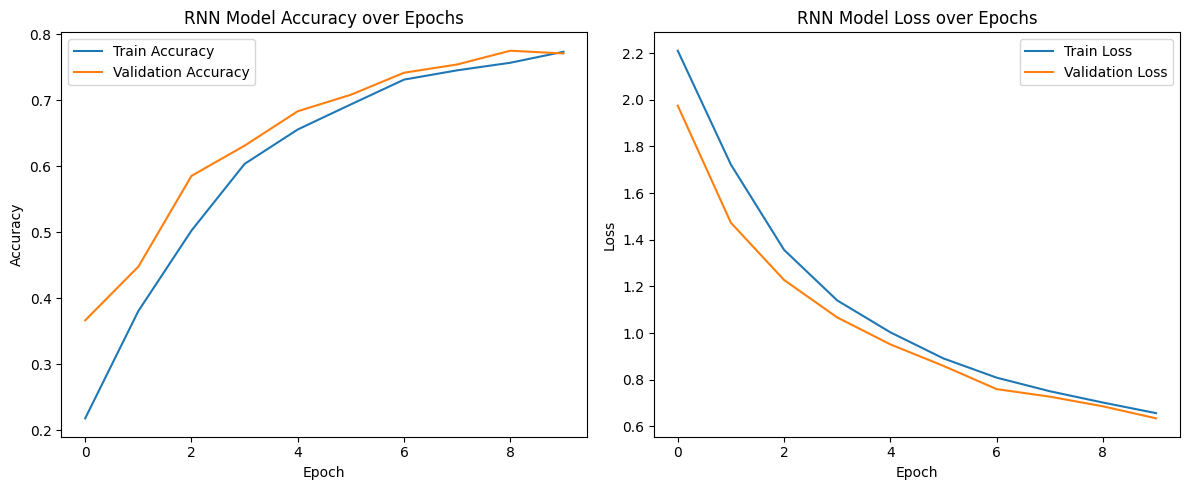

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_rnn_1.history['loss'], label='Train Loss')
plt.plot(history_rnn_1.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


### Increasing no of epochs

In [51]:
model_rnn_2 = tf.keras.models.Model(inputs=input_layer, outputs=d3)
model_rnn_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_rnn_2 = model_rnn_2.fit(X_train_spectrogram, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
60/60 [==============================] - 9s 130ms/step - loss: 0.6202 - accuracy: 0.7839 - val_loss: 0.6622 - val_accuracy: 0.7583
Epoch 2/20
60/60 [==============================] - 7s 112ms/step - loss: 0.5774 - accuracy: 0.7990 - val_loss: 0.6196 - val_accuracy: 0.7750
Epoch 3/20
60/60 [==============================] - 8s 130ms/step - loss: 0.5548 - accuracy: 0.8115 - val_loss: 0.5699 - val_accuracy: 0.7875
Epoch 4/20
60/60 [==============================] - 9s 146ms/step - loss: 0.5329 - accuracy: 0.8120 - val_loss: 0.5359 - val_accuracy: 0.8188
Epoch 5/20
60/60 [==============================] - 9s 143ms/step - loss: 0.5135 - accuracy: 0.8156 - val_loss: 0.5480 - val_accuracy: 0.8000
Epoch 6/20
60/60 [==============================] - 8s 138ms/step - loss: 0.5112 - accuracy: 0.8182 - val_loss: 0.5446 - val_accuracy: 0.8271
Epoch 7/20
60/60 [==============================] - 8s 137ms/step - loss: 0.4923 - accuracy: 0.8318 - val_loss: 0.4870 - val_accuracy: 0.8208
Epoch 

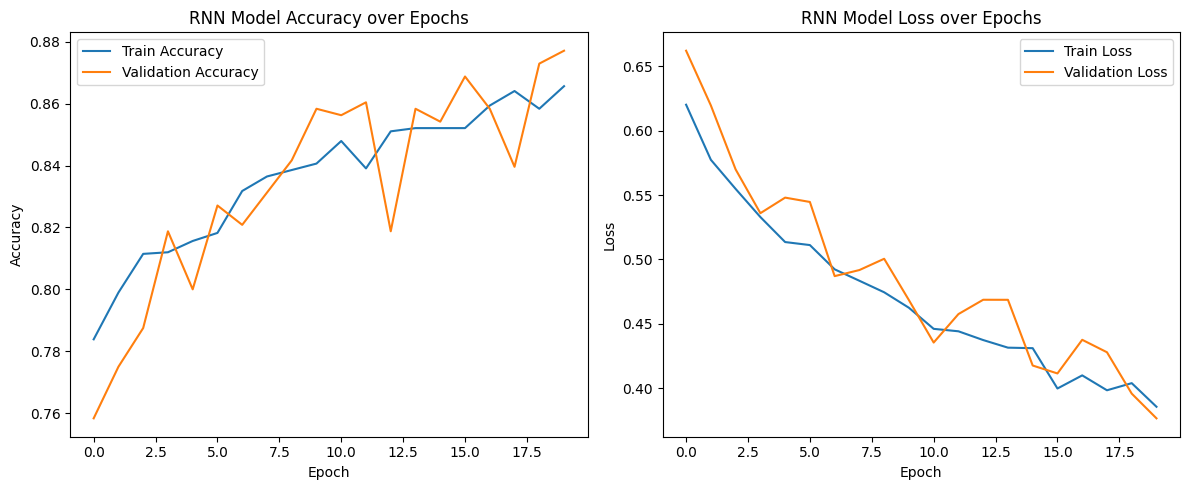

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn_2.history['loss'], label='Train Loss')
plt.plot(history_rnn_2.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
epochs_rnn_1 = len(history_rnn_1.history['accuracy'])  
model_rnn_1_results = pd.DataFrame({
    'Model': ['RNN Model 1'],
    'Epochs': [epochs_rnn_1],
    'Train Accuracy': [history_rnn_1.history['accuracy'][-1]],
    'Validation Accuracy': [history_rnn_1.history['val_accuracy'][-1]],
    'Train Loss': [history_rnn_1.history['loss'][-1]],
    'Validation Loss': [history_rnn_1.history['val_loss'][-1]]
})

epochs_rnn_2 = len(history_rnn_2.history['accuracy'])  
model_rnn_2_results = pd.DataFrame({
    'Model': ['RNN Model 2'],
    'Epochs': [epochs_rnn_2],
    'Train Accuracy': [history_rnn_2.history['accuracy'][-1]],
    'Validation Accuracy': [history_rnn_2.history['val_accuracy'][-1]],
    'Train Loss': [history_rnn_2.history['loss'][-1]],
    'Validation Loss': [history_rnn_2.history['val_loss'][-1]]
})

rnn_model_comparison_df = pd.concat([model_rnn_1_results, model_rnn_2_results], ignore_index=True)
print(rnn_model_comparison_df)


         Model  Epochs  Train Accuracy  Validation Accuracy  Train Loss  \
0  RNN Model 1      10        0.773438             0.770833    0.656908   
1  RNN Model 2      20        0.865625             0.877083    0.385525   

   Validation Loss  
0         0.634634  
1         0.376532  


## Final Comparision

In [57]:
final_model_comparison_df = pd.concat([model_comparison_df, rnn_model_comparison_df], ignore_index=True)
print(final_model_comparison_df)


         Model Epochs  Train Accuracy  Validation Accuracy  Train Loss  \
0  CNN Model 1     10        0.935417             0.895000    0.617536   
1  CNN Model 2     20        0.973333             0.951667    0.364210   
2  CNN Model 3      5        0.989167             0.593333    0.048140   
3  RNN Model 1     10        0.773438             0.770833    0.656908   
4  RNN Model 2     20        0.865625             0.877083    0.385525   

   Validation Loss  
0         0.654126  
1         0.758135  
2         1.544981  
3         0.634634  
4         0.376532  
